In [1]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.geometry import Point
import shapely.ops as ops
from shapely.ops import cascaded_union

from shapely import geometry
import itertools
import geopandas as gpd
import pandas as pd

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib

import os
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import datetime
from tqdm.notebook import tqdm
from scipy.spatial import distance
from functools import partial
import pyproj
from shapely.ops import transform
from gbdxtools import Interface
from fiona.crs import from_epsg
gbdx = Interface()
from keras.models import load_model

import rasterio
import random

Using TensorFlow backend.


# Load The Model And Run Inference

In [3]:
variable_selection = range(17)

property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

save_classification = True

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    if rgb.mean() > 1:
        rgb[rgb > 255] = 255
    else: 
        rgb[rgb > 1] = 1
    
    return rgb

/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif
3545718/3545718 [==============================] - 28s 8us/step


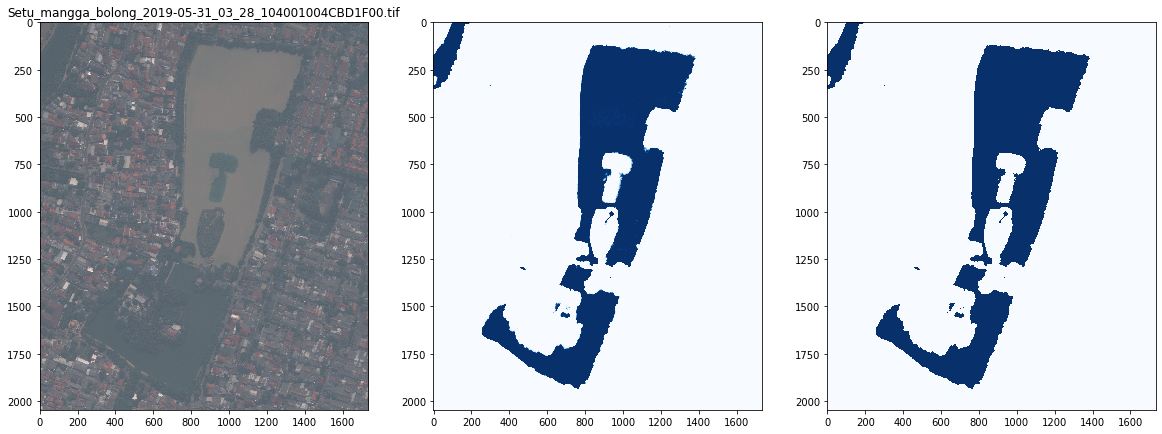

saved as:  /home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif
/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_rawa_babon_2019-07-27_03_34_10400100503B3A00.tif
3036682/3036682 [==============================] - 26s 9us/step


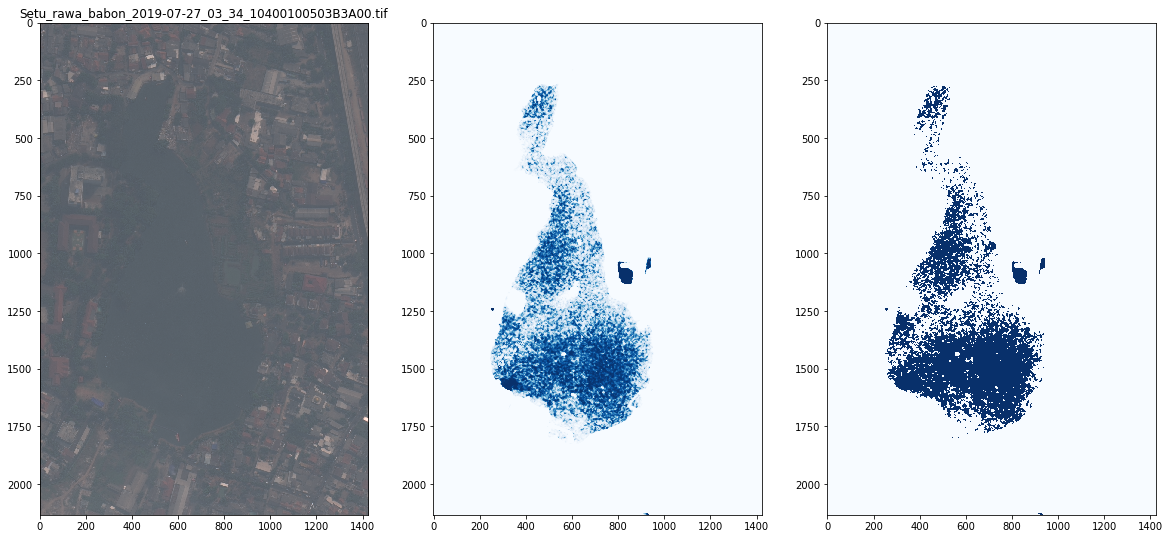

saved as:  /home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/raster_classifications/classification_Setu_rawa_babon_2019-07-27_03_34_10400100503B3A00.tif
/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif
7388599/7388599 [==============================] - 59s 8us/step


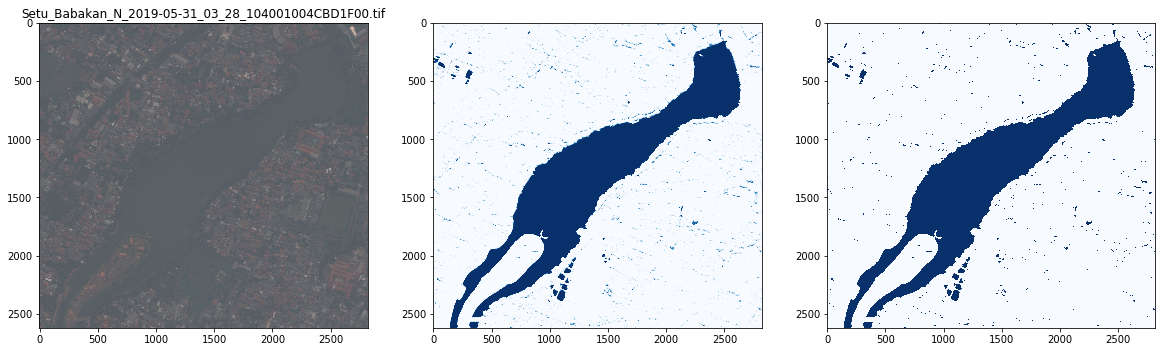

saved as:  /home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/raster_classifications/classification_Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif


In [9]:
def run_the_inference(model_weight_path = None, raster_files_path = None, output_file_path = 'classification/'):
    path = Path(raster_files_path)
    if raster_files_path is not None \
        and os.path.exists(path.parent) \
        and model_weight_path is not None \
        and os.path.exists(model_weight_path):
        model = load_model(model_weight_path)
        
        raster_files = glob(raster_files_path)
        if len(raster_files) == 1:
            sample_size = 1
        else:
            sample_size = 3
        for file_path in np.array(pd.DataFrame(raster_files).sample(sample_size)).flatten(): 
    
            print(file_path)
            filename = file_path.split('/')[-1]

            data = rasterio.open(file_path).read()
            dataset = rasterio.open(file_path)

            transform = dataset.meta['transform']
            width = dataset.meta['width']
            height = dataset.meta['height']

            # Split image data into band layers
            coastal = data[0] 
            blue    = data[1]
            green   = data[2]
            yellow  = data[3]
            red     = data[4] 
            red_edge = data[5] 
            nir1 = data[6]
            nir2 = data[7]

            # get info from filenames
            stringlist = file_path.split('/')[-1].split('_')
            image_id = stringlist[-1].split('.')[0]

            # get metadata from GBDX
            record = gbdx.catalog.get(image_id)

            # add metadata to data 
            i = 8
            for property_name in property_names:

                    try: 
                        property_record = record['properties'][property_name]  

                        property_array = np.empty([1,data.shape[1],data.shape[2]])
                        property_array.fill(property_record)

                        data = np.vstack([data,property_array])
                    except: 
                        print('failed ', property_name, image_id)
                        property_array = np.empty([1,data.shape[1],data.shape[2]])
                        data = np.vstack([data,property_array])

                    i = i + 1


            # Calculate indices
            # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
            ndvi = reshape((nir1 - red)/(nir1 + red))
            ndwi = reshape((green - nir1) / (green + nir1))
            wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

            # Stack arrays in sequence vertically (row wise)
            image_array = np.vstack([data,ndvi,ndwi, wwi])
            # select all variables of interest
            image_array = image_array[variable_selection,:,:]

            ### Reshape the data prior to feeding it through the model.
            # Flatten the two-dimensional imagery (i.e., Reshape)
            d2, h2, w2 = image_array.shape
            data_pred = np.reshape(image_array,(d2,h2*w2)).T
                
            # Convert data type to 32-bit float, and normalize between 0 and 1
            data_pred.astype(np.float32)
            
            min_data =  np.nanmin(data_pred)
            max_data = np.nanmax(data_pred)
            
            data_pred = (data_pred - min_data) / (max_data - min_data)

            # Next, conduct model prediction on each spectral column
            labels_pred = model.predict(data_pred, verbose = 1, workers = 4)
            labels_pred = np.reshape(labels_pred,(h2,w2))

            ### Calculate threshold for classification  
            thresh = filters.threshold_otsu(labels_pred)

            ### Plot the input image alongside its corresponding predictions.
            plt.figure(figsize=(20,20))
            plt.subplot(131);plt.imshow(rgb_from_raster(data, 0.0)); plt.title(filename)
            plt.subplot(132);plt.imshow(labels_pred, cmap = 'Blues');
            # plt.colorbar()
            plt.subplot(133);plt.imshow(labels_pred > 0.4, cmap = 'Blues');
            plt.draw()
            plt.show()

            ### save classifications to raster
            labels_pred = labels_pred.astype(float)

            array_classification = labels_pred > thresh
            array_classification = array_classification.astype(float)

            classification_filename = output_file_path + 'classification_' + filename

            if save_classification:
                with rasterio.open(
                    classification_filename,
                    'w',
                    driver='GTiff',
                    height=labels_pred.shape[0],
                    width=labels_pred.shape[1],
                    count=1,
                    dtype=labels_pred.dtype,
                    crs='+proj=latlong',
                    transform=transform,
                ) as dst:
                    dst.write(labels_pred, 1)


                print('saved as: ', classification_filename)
model_weight_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/model_weight/bfalg_batchSize_200_Epoch-00185-Val_acc-0.95145_weights.hdf5'
raster_files_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/*.tif'
output_file_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/raster_classifications/'

run_the_inference(model_weight_path, raster_files_path, output_file_path)

# Vectorize The Inference

In [4]:
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines

500.0 sq. m
3125 grid cells


/home/daffolap-851/.conda/envs/green_city_watch_dev/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


(2621, 2819)


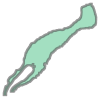

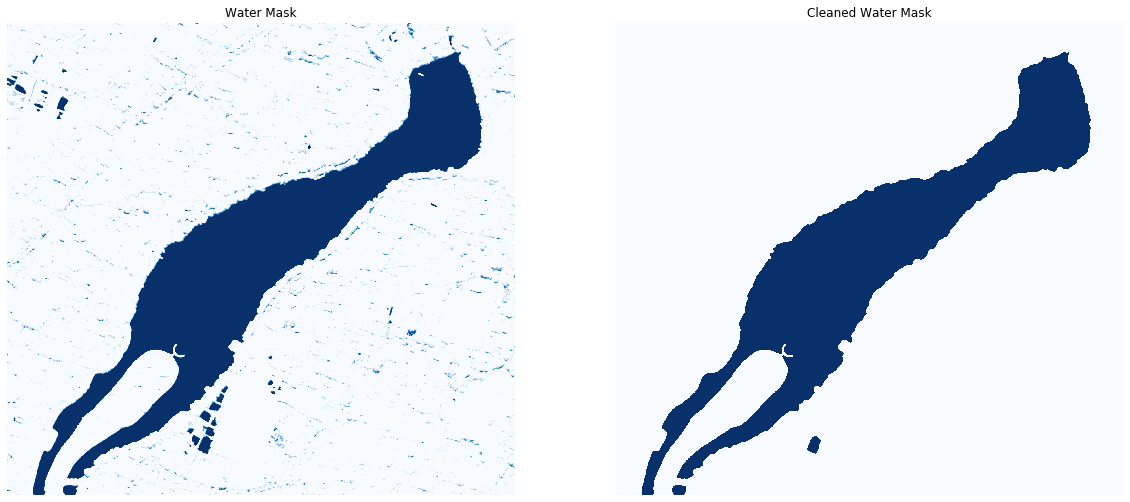

In [23]:
def get_detected_water_bodies_polygon(inference_img_file_path=None):
    
    if inference_img_file_path is not None \
        and os.path.exists(inference_img_file_path):
        
        inference_data = rasterio.open(inference_img_file_path).read()
        inference_dataset = rasterio.open(inference_img_file_path)

        affine = inference_dataset.meta['transform']
        width = inference_dataset.meta['width']
        height = inference_dataset.meta['height']
        
        thresh = filters.threshold_otsu(inference_data[0])
        data_otsu_treshold = inference_data[0] > thresh
        water_data = data_otsu_treshold.astype('uint8')
        
        # rescale values to 0 - 255 to use image processing algorithms
        OldRange = (water_data.max() - water_data.min())  
        NewRange = (0 - 255)  
        NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

        water_data = NewValue.round().astype('uint8')

        water_blurred = cv.medianBlur(water_data,15)

        # Specify the minimum feature size in square meters, and then use info from the image metadata 
        # to translate to grid cell count.

        # Set the minimum feature size to 400 sq km (400,000 m)
        min_feature_size_m2 = 500.

        # From the image metadata, we can determine the area of a single grid cell
        try: 
            cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
        except: 
            cell_height_m = 0.40

        cell_area_m2 = cell_height_m**2

        # Finally, use the cell size to convert the minimum feature size to grid cells
        min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

        # What is the minimum feature size in square meters and grid cells?
        print(min_feature_size_m2, 'sq. m')
        print(min_feature_size_cells, 'grid cells')

        # First, remove the small holes
        water_cleaned = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

        # Then remove the small objects
        water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)
        
        # View the results
        plt.figure(figsize=(20,15))
        
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(inference_data[0], vmin=0, vmax=1, cmap = 'Blues')
        plt.title("Water Mask")

        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
        plt.title("Cleaned Water Mask")
        print(water_cleaned.shape)
        
        water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

        # Run a basic simplification algorithm to smooth the lines
        water_lines_smooth = [g.simplify(0.001) for g in water_lines]

        # GLue it all together
        detection = cascaded_union(water_lines)
        
        detection_poly = ops.polygonize_full(detection)

        detection_poly = cascaded_union(detection_poly)

        buffer = 0# 1e-05

        detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)
        detection_poly = ops.polygonize_full(detection_poly_smooth)[0]
        return detection_poly

inference_img_file_path ='/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif'    
inference_img_file_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/raster_classifications/classification_Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif'
res = get_detected_water_bodies_polygon(inference_img_file_path)
res[0]

# Plot Over Satellite Image

500.0 sq. m
3125 grid cells


/home/daffolap-851/.conda/envs/green_city_watch_dev/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


(2621, 2819)


/home/daffolap-851/.conda/envs/green_city_watch_dev/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


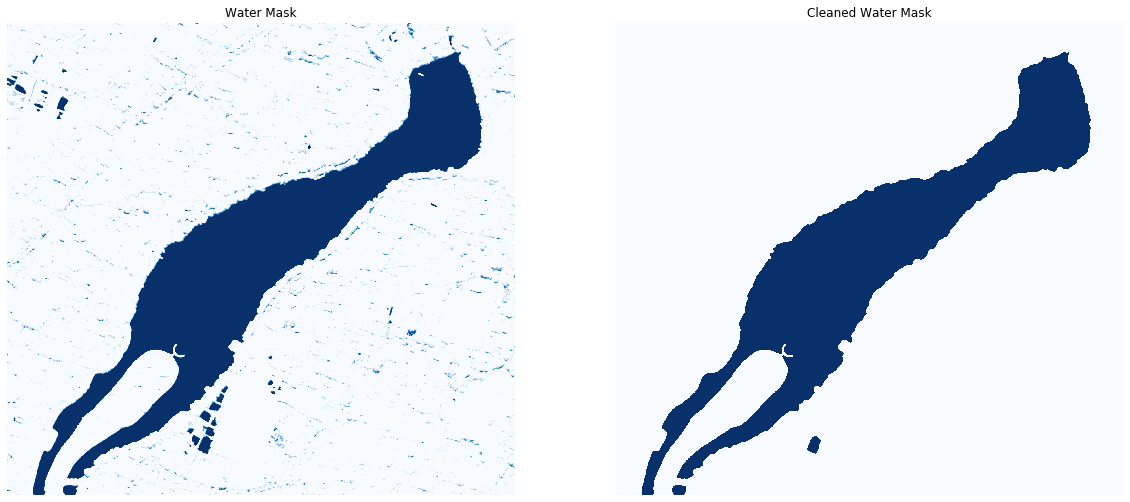

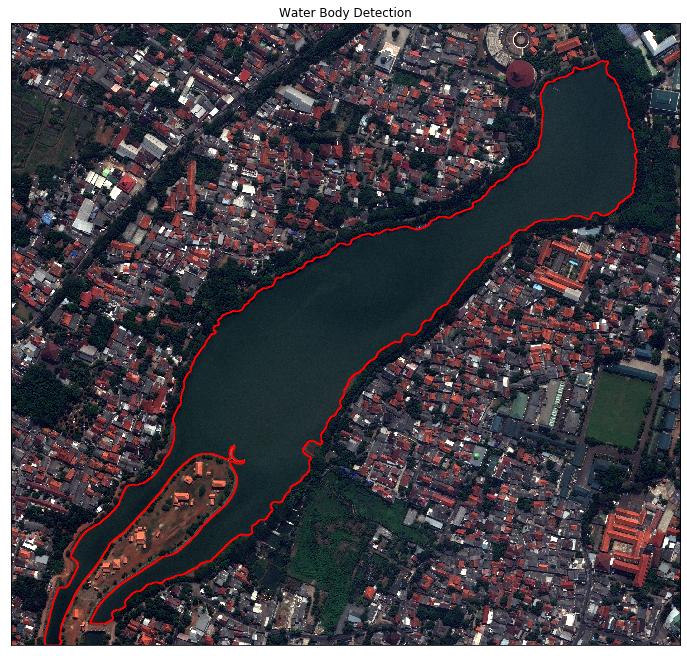

In [27]:
def plot_boundary_overlayed_on_rgb_img(polygon=None, raster_image_path=None):
    if os.path.exists(raster_image_path) \
        and polygon is not None:
        raster_img = rasterio.open(raster_image_path)
        raster_profile = raster_img.profile
        bound = gpd.GeoSeries(polygon)
        bound = gpd.GeoDataFrame({'geometry': bound}, index=[0],  crs=from_epsg(4326))

        bound_utm13N = bound.to_crs(raster_profile["crs"])
        extent = plotting_extent(raster_img.read()[0], raster_profile["transform"])

        # Create figure with one plot
        fig, ax = plt.subplots(figsize=(12, 12))

        # Plot boundary with high zorder for contrast
        bound_utm13N.boundary.plot(ax=ax, color="red", zorder=10)

        # Plot CIR image using the raster extent
        ep.plot_rgb(
            raster_img.read(),
            rgb=(4, 2, 1),
            ax=ax,
            stretch=True,
            extent=extent,
            str_clip=0.5,
            title="Water Body Detection",
        )
        plt.show()
    else:
        print("The path does not exist or there is none polygon object")

res = get_detected_water_bodies_polygon(inference_img_file_path)
raster_image_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif'
plot_boundary_overlayed_on_rgb_img(polygon=res[0], raster_image_path=raster_image_path)

# Get User Input

In [29]:
def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

def polygon_raster_overlap(poly, n_closest, raster_files):    
    for n in n_closest:     

        # load raster data
        dataset = rasterio.open(raster_files[n])

        # convert bounds to polygon
        left, bottom, right, top = dataset.bounds
        polygon = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])

        # calculate overlap fraction
        overlap_area = round(poly.intersection(polygon).area / poly.area, 2)

        if overlap_area == 1:
            break  
    
    return n

def random_points_within(poly, n_points_per_sqm):
    min_x, min_y, max_x, max_y = poly.bounds
    
    epsg = wgs2epsgzone(max_x, max_y)
    
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:%i'  % (epsg)))


    poly_wgs = transform(project, poly)
    
    n_points = int((poly_wgs.area / 1e6) * n_points_per_sqm)
    
    if n_points > 10000:
        n_points = 10000
    
    if n_points < 10:
        n_points = 50
    
#     print('area ' + str(poly_wgs.area))
#     print('n_points ' + str(n_points))

    points = []

    while len(points) < n_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points


def get_values_for_points(dataset, points):

    bands_save = []
    x_save = []
    y_save = []
    
    data_array = dataset.read()

    for i in range(len(points)):
        x = points[i].x
        y = points[i].y

        x_save.append(x)
        y_save.append(y)

        index = dataset.index(x, y)

        try: 
            band_values = data_array[:,index[0],index[1]]
            bands_save.append(band_values)
        except:
            # print('point ' + str(i) + ' out of image')
            continue

#         print(band_values)
        
    return bands_save, x_save, y_save

def get_data_raster_polygons(class_MultiPolygon, variables, image_locations, raster_files, plotting_overlap = False):
    
    nr_of_polygons = len(class_MultiPolygon)

    # create dataframe with all variables + label
    variables_str_list= variables + ['label']
    df_subsample = pd.DataFrame(columns = variables_str_list)

    # len(df_polygon_image_id)
    for i in tqdm(range(nr_of_polygons)):

        # select polygon
        poly = class_MultiPolygon[i]

        # get polygon location as shapely obj.
        [x,y] = poly.centroid.xy
        point = np.array([x[0],y[0]])

        # get index of closest 5 images to polygon
        n_closest = distance.cdist([point], image_locations).argsort()[0,0:5]

        # check overlap for each image agianst the polygon
        n_maxoverlap = polygon_raster_overlap(poly, n_closest, raster_files)

        # get raster corresponding to polygon
        path_match_image = raster_files[n_maxoverlap]
        
        # create random samples in polygon
        samples = random_points_within(poly, n_points_per_sqkm)
        
        df = pd.DataFrame(np.zeros([len(samples),len(variables)]),  columns = variables)

        # get band values for random samples
        dataset = rasterio.open(path_match_image)
        bands_save, x_save, y_save = get_values_for_points(dataset, samples)

        # visualize training data selection
        try: 
            if plotting_overlap:
                # clear_output(wait = True)

                # get boundary xy coordinates for plotting
                try:       
                    if len(poly.boundary) == 1:
                        x,y = poly.boundary.xy
                    else:
                        n_largest = np.array([boundary.length for boundary in poly.boundary]).argmax()
                        x,y = poly.boundary[n_largest].xy
                except: 
                    x,y = poly.boundary.xy                

                data = dataset.read()
                data = data - np.min(data)
                data = data / np.maximum(np.max(data), 1) + 0.3

                plt.figure(figsize = (10,10))
                plt.plot(x,y, color = 'w')
                for point in samples:
                    plt.scatter(point.x,point.y, c = 'red', marker = '.')
                show(data[[1,3,4],:,:], transform=dataset.transform)
        except Exception as e:
            print('failed')
            print('poly nr: ', i, ' image: ', path_match_image)
            print(e)
            print('___________________________________________\n')

        # plt.show()

        try:
            df.loc[:,0:8] = bands_save
            # print('data', start_row, end_row)
        except: 
            print('no data', path_match_image)
            continue

        # get image_id from filename
        stringlist = path_match_image.split('/')[-1].split('_')
        image_id = stringlist[-1].split('.')[0]

        # get metadata 
        record = gbdx.catalog.get(image_id)
        df.loc[:,'x'] = x_save
        df.loc[:,'y'] = y_save

        for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]    
                df[property_name] = property_record
            except: 
                print('failed ', property_name, image_id)
                df[property_name] = None

        df['label'] = label

        df_subsample = df_subsample.append(df, ignore_index=True)
    
    return df_subsample

def raster_path_list2image_centroid_coordinate(raster_path_list):
    
    image_locations = np.zeros([len(raster_path_list), 2])

    i = 0

    for path in tqdm(raster_path_list):

        dataset = rasterio.open(path)

        # get info from filenames
        stringlist = path.split('/')[-1].split('_')
        seq_nr = stringlist[1]
        image_id = stringlist[-1].split('.')[0]
        city = stringlist[0]

        # calculate center of image 
        left, bottom, right, top = dataset.bounds
        x_center = (left + right) / 2
        y_center = (top + bottom) / 2

        image_locations[i,0] = x_center
        image_locations[i,1] = y_center


        i = 1 + i
    
    return image_locations

In [30]:
def get_user_input(polygon=None, raster_image_path=None):
    plot_boundary_overlayed_on_rgb_img(polygon=polygon, raster_image_path=raster_image_path)
    user_input = input('Is it water?: y/n\n')
    return user_input


# Store User Input

In [31]:
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

variables = [0, 1, 2, 3, 4, 5, 6, 7, 'x', 'y'] + property_names

def store_user_input(polygon=None, raster_image_path=None, label=None):
    image_locations = raster_path_list2image_centroid_coordinate([raster_image_path])
    df =  get_data_raster_polygons([polygon], 
                                      variables,
                                      image_locations,
                                      [raster_image_path],
                                      plotting_overlap = True)
    return df

# Main Function To Start

In [ ]:
training_dataframe = pd.DataFrame()
n_points_per_sqkm = 5000
raster_image_path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif'
detection_poly = get_detected_water_bodies_polygon(inference_img_file_path)
for poly in detection_poly:
    raster_image_path = input('Enter the original raster image path\n').strip()
    user_input = get_user_input(poly, raster_image_path)
    if user_input == 'y':
        label = 'water'
        training_dataframe = pd \
                                .concat([training_dataframe,store_user_input(poly, raster_image_path,label)])
    else:
        label = 'non_water'
        training_dataframe = pd \
                                .concat([training_dataframe,store_user_input(poly, raster_image_path,label)])


500.0 sq. m
3125 grid cells


/home/daffolap-851/.conda/envs/green_city_watch_dev/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


(2621, 2819)
Enter the original raster image path
/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif


/home/daffolap-851/.conda/envs/green_city_watch_dev/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
